# BD II (Columnares: HBase)

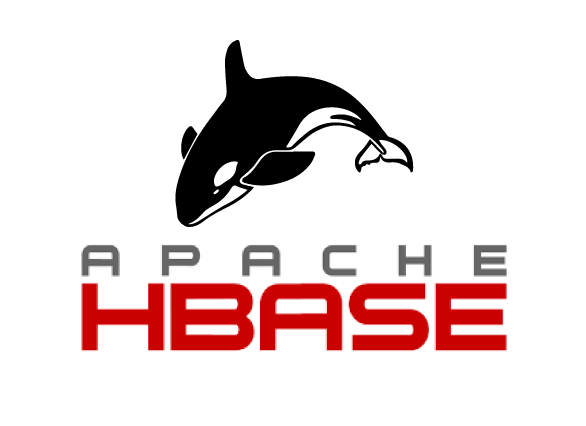



Esta hoja muestra cómo acceder a bases de datos HBase y también a conectar la salida con Jupyter.

Se puede utilizar el *shell* propio de HBase en la máquina virtual.

Con HBase vamos a simular un modo _semi-clúster_ con una sola máquina.


Primero ajustamos la variable de entorno `JAVA_HOME`, necesaria para HBase.

In [20]:
RunningInCOLAB = 'google.colab' in str(get_ipython()) if hasattr(__builtins__,'__IPYTHON__') else False

In [21]:
if not RunningInCOLAB:
    !sudo apt-get update -qq
    !sudo apt-get install -y -qq default-jdk p7zip

In [22]:
# Search for the first java interpreter. This code should work. If not, adjust JAVA_HOME manually.
import os
from pathlib import Path

def find_java_home() -> str | None:
  p  = Path('/usr/lib/jvm')
  (_, dirs, _) = next(os.walk(p))
  for d in dirs:
    inner_java: Path = p / d / 'bin' / 'java'
    if inner_java.is_file() and inner_java.stat().st_mode & 0o111:
        return str(p.joinpath(d).absolute())
  return None

JAVA_HOME: str | None = os.getenv('JAVA_HOME', find_java_home())

In [23]:
%env JAVA_HOME=$JAVA_HOME

env: JAVA_HOME=/usr/lib/jvm/java-1.11.0-openjdk-amd64


In [24]:
%pip install bs4 lxml

In [25]:
# Determinar qué versión 2.x de HBase es la más reciente.
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
from functools import reduce
import re
from re import Pattern

version_re: Pattern = re.compile(r'^(2\.[0-9]+(\.[0-9]+)?)')
req = Request("https://downloads.apache.org/hbase/")
html_page = urlopen(req)

soup = BeautifulSoup(html_page)
bigger2x: str = reduce(max,
                       [m.group(0) for m in [version_re.match(link.get_text()) for link in soup.find_all('a')] if m],
                       '2.0.0') # Base version 2.x.x

In [26]:
%env HBASE_VERSION=$bigger2x

env: HBASE_VERSION=2.6.2


In [27]:
%%sh
wget -q https://downloads.apache.org/hbase/$HBASE_VERSION/hbase-$HBASE_VERSION-bin.tar.gz
tar -xzf hbase-$HBASE_VERSION-bin.tar.gz
rm -rf hbase-$HBASE_VERSION-bin.tar.gz

In [28]:
%%sh
hbase-$HBASE_VERSION/bin/start-hbase.sh
hbase-$HBASE_VERSION/bin/hbase-daemon.sh restart thrift

running master, logging to /content/hbase-2.6.2/bin/../logs/hbase--master-93112d9b82e9.out
running thrift, logging to /content/hbase-2.6.2/bin/../logs/hbase--thrift-93112d9b82e9.out
running thrift, logging to /content/hbase-2.6.2/bin/../logs/hbase--thrift-93112d9b82e9.out
no thrift to stop because no pid file /tmp/hbase--thrift.pid
running thrift, logging to /content/hbase-2.6.2/bin/../logs/hbase--thrift-93112d9b82e9.out


In [29]:
from pprint import pprint as pp

Descargamos los ficheros de *stackoverflow* para trabajar con ellos en HBase.

In [30]:
%%sh
wget -q https://github.com/dsevilla/bd2-data/raw/main/es.stackoverflow/es.stackoverflow.csv.7z.001
wget -q https://github.com/dsevilla/bd2-data/raw/main/es.stackoverflow/es.stackoverflow.csv.7z.002

In [31]:
%%sh
7zr x es.stackoverflow.csv.7z.001
rm -rf es.stackoverflow.csv.7z.001
rm -rf es.stackoverflow.csv.7z.002


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
1 file, 104857600 bytes (100 MiB)

Extracting archive: es.stackoverflow.csv.7z.001
--
Path = es.stackoverflow.csv.7z.001
Type = Split
Physical Size = 104857600
Volumes = 2
Total Physical Size = 200457538
----
Path = es.stackoverflow.csv.7z
Size = 200457538
--
Path = es.stackoverflow.csv.7z
Type = 7z
Physical Size = 200457538
Headers Size = 248
Method = LZMA2:24
Solid = +
Blocks = 1


Would you like to replace the existing file:
  Path:     ./Comments.csv
  Size:     160819553 bytes (154 MiB)
  Modified: 2024-01-21 23:51:00
with the file from archive:
  Path:     Comments.csv
  Size:     160819553 bytes (154 MiB)
  Modified: 2024-01-21 23:51:00
? (Y)es / (N)o / (A)lways / (S)kip all / A(u)to rename all / (Q)uit? 

terminate called after throwing an instance of 'char const*'
Aborted (core dumped)


In [32]:
!head Users.csv
!grep ^13818 Comments.csv


Id,AboutMe,AccountId,CreationDate,DisplayName,DownVotes,LastAccessDate,Location,Reputation,UpVotes,Views,WebsiteUrl
-1,"<p>Hola, no soy una persona real.</p><br/><br/><p>¡Soy un proceso que ayuda a mantener el sitio limpio!</p><br/><br/><p>Hago cosas como:</p><br/><br/><ul><br/><li>Dar empujoncitos a preguntas antiguas sin respuesta aproximadamente cada hora, para que atraigan algo de atención.</li><br/><li>Tener la propiedad de las preguntas y respuestas wiki para que nadie se lleve reputación por ellas</li><br/><li>Recibir la propiedad de los votos negativos en las publicaciones de spam o dañinas que son borradas permanentemente</li><br/><li>Tener la propiedad de las ediciones sugeridas por usuarios anónimos</li><br/><li><a href=""http://meta.stackoverflow.com/a/92006"">Quitar preguntas abandonadas</a></li><br/></ul><br/>",-1,2015-10-26T21:36:24.767,Comunidad,22504,2015-10-26T21:36:24.767,en la granja de servidores,1,10211,2516,
1,"<p>Dev #2 who helped create Stack Overflow currently

Usaremos la librería `happybase` para python. La cargamos a continuación y hacemos la conexión.

In [33]:
%pip install git+https://github.com/python-happybase/happybase.git

  Cloning https://github.com/python-happybase/happybase.git to /tmp/pip-req-build-z59_yued
  Running command git clone --filter=blob:none --quiet https://github.com/python-happybase/happybase.git /tmp/pip-req-build-z59_yued
  Resolved https://github.com/python-happybase/happybase.git to commit 656409902bd6d411950232d50ed541196e993760
  Preparing metadata (setup.py) ... done


La conexión con la BD dura pocos segundos abierta porque está pensada para que un programa se conecte, haga una consulta y se desconecte. Al estar en una sesión interactiva, construyo un objeto `Connection` que genera un pool de conexiones. Si se desconecta, prueba otra vez.

In [34]:
from collections.abc import Generator
import happybase
from happybase import ConnectionPool
from contextlib import contextmanager

HBASEHOST: str = 'localhost'

class Connection():

    def __init__(self, host: str):
        self.host: str = host
        self._genpool()

    def _genpool(self):
        self.pool = ConnectionPool(size=20, host=self.host, autoconnect=True)

    @contextmanager
    def connection(self) -> Generator[happybase.Connection, None, None]:
        for _ in range(5): # Probar 5 veces a regenerar el pool
            for _ in range(5): # Probar 5 veces a conectar
                with self.pool.connection() as connection:
                    try:
                        connection.tables()
                        yield connection
                        return
                    except Exception as _:
                        pass
            self._genpool()
        raise Exception("HBase Connection Error")

In [35]:
pool = Connection(HBASEHOST)

Para la carga inicial, vamos a crear todas las tablas con una única familia de columnas, `rawdata`, donde meteremos toda la información _raw_ comprimida. Después podremos hacer reorganizaciones de los datos para hacer el acceso más eficiente. Es una de las muchas ventajas de no tener un esquema.

In [36]:
# Create tables
tables: list[str] = ['posts', 'votes', 'users', 'tags', 'comments']
with pool.connection() as connection:
    for t in tables:
        try:
          connection.create_table(
                t,
                {
                    'rawdata': dict(max_versions=1,compression='GZ')
                })
        except Exception as e:
            print("Database already exists: {0}. {1}".format(t, e))
            pass

with pool.connection() as connection:
    print(connection.tables())

[b'comments', b'posts', b'tags', b'users', b'votes']


### Carga de los datos

El código de importación es siempre el mismo, ya que se coge la primera fila del CSV que contiene el nombre de las columnas y se utiliza para generar nombres de columnas dentro de la familia de columnas dada como parámetro. La función `csv_to_hbase()` acepta un fichero CSV a abrir, un nombre de tabla y una familia de columnas donde agregar las columnas del fichero CSV. En nuestro caso siempre va a ser `rawdata`.

In [37]:
import csv
from happybase import Table

def csv_to_hbase(file: str, tablename: str, column_family: str) -> None:
    with pool.connection() as connection, open(file) as f:
        table: Table = connection.table(tablename)

        # La llamada csv.reader() crea un iterador sobre un fichero CSV
        reader = csv.reader(f, dialect='excel')

        # Se leen las columnas. Sus nombres se usarán para crear las diferentes columnas en la familia
        columns: list[str] = next(reader)
        columns = [column_family + ':' + c for c in columns]

        with table.batch(batch_size=500) as b:
            for row in reader:
                # La primera columna se usará como Row Key
                b.put(row[0], dict(zip(columns[1:], row[1:])))

La carga de los datos tarda tiempo, por lo que se hace en parlelo y en segundo plano para que podamos continuar con el notebook. Se utiliza el paradigma de "futures", una abstracción que permite dejar pendiente una computación en segundo plano, y obtenerla finalmente, o esperar a que termine, preguntar de vez en cuando, etc.

In [38]:
from concurrent.futures import Future

futures: dict[str, Future | None] = {t: None for t in tables}

In [39]:
from collections.abc import Iterable
from concurrent.futures import ThreadPoolExecutor

def import_table(t):
  print(f"Importando tabla {t}...")
  csv_to_hbase(t.capitalize() + '.csv', t, 'rawdata')
  return True

def background_import_tables() -> Iterable[Future[bool]]:
  e = ThreadPoolExecutor(len(tables))
  _futures = map(lambda t: e.submit(import_table, t), tables)
  return _futures

if not any(futures.values()):
  futures = dict(zip(tables, background_import_tables()))
else:
  print(f"Futures running: {any(futures.values())}. If not running, put futures=None",
        " and try again. This is to prevent running several works in background.")

Importando tabla posts...
Importando tabla votes...
Importando tabla users...
Importando tabla tags...
Importando tabla comments...


La siguiente línea muestra los "futures" que todavía están ejecutándose. Cuando se haya importado todo, todos los futures pondrán su running a False. Mientras tanto podemos continuar con el resto del Notebook.

In [40]:
f"Futures running: {dict(zip(tables, [f.running() for f in futures.values()]))}."

"Futures running: {'posts': True, 'votes': True, 'users': True, 'tags': True, 'comments': True}."

In [41]:
# Si no se está ejecutando en Google Colab, esperar a que terminen los trabajos en segundo plano.

if not RunningInCOLAB:
  from concurrent.futures import as_completed
  for f in as_completed(futures.values()):
    f.result()

### Consultas sencillas desde Python

A continuación veremos algunas consultas sencillas desde python usando el API de `happybase`.
Obtener el Post con `Id` 5. La orden más sencilla e inmediata de HBase es obtener una fila, opcionalmente limitando las columnas a mostrar:

In [42]:
# Muestra cómo queda la fila del Id del Post 5
with pool.connection() as connection:
    posts_table: Table = connection.table('posts')
    pp(posts_table.row(b'5'))

{}


In [43]:
with pool.connection() as connection:
    posts_table: Table = connection.table('posts')
    pp(posts_table.row(b'5',columns=[b'rawdata:Body']))

{}


In [44]:
with pool.connection() as connection:
    posts_table: Table = connection.table('posts')
    pp(posts_table.row(b'5',columns=[b'rawdata:AnswerCount',b'rawdata:AcceptedAnswerId']))

{}


Y también se puede recorrer como un diccionario normal (el `decode` se utiliza para convertir los valores binarios de la base de datos a una codificación UTF-8):

In [45]:
with pool.connection() as connection:
    posts_table: Table = connection.table('posts')
    row: dict = posts_table.row(b'5')
    for key, value in row.items():
        print("Key = '%s', Value = '%s'" % (key, value.decode()[:40]))

Finalmente, también se puede recorrer toda la tabla estableciendo filtros, que se estudiarán después. Se utiliza la función `scan`. Se puede iterar con los parámetros `key` y `data`. Por ejemplo, calcular el tamaño máximo de la longitud del texto de los posts:

**(OJO, es un ejemplo, no se debería hacer así)**

In [46]:
max_len = 0
with pool.connection() as connection:
    posts_table: Table = connection.table('posts')
    for key, data in posts_table.scan():
        cur_len = len(data[b'rawdata:Body'].decode())
        if cur_len > max_len:
            max_len = cur_len

print("Máxima longitud: %s caracteres." % (max_len))

Máxima longitud: 0 caracteres.


### Construcción de estructuras anidadas

Al igual que pasaba con MongoDB, las bases de datos NoSQL como en este caso HBase permiten almacenar estructuras de datos complejas. En nuestro caso vamos a agregar los comentarios de cada pregunta o respuesta (post) en columnas del mismo. Para ello, creamos una nueva familia de columnas `comments`.

HBase es bueno para añadir columnas sencillas, por ejemplo que contengan un valor. Sin embargo, si queremos añadir objetos complejos, tenemos que jugar con la codificación de la familia de columnas y columna.

Usaremos el shell porque `happybase` no permite alterar tablas ya creadas. Para acceder al shell de HBase, tenemos que contactar al contenedor `hbase-regionserver`, de esta forma:

```bash
hbase-$HBASE_VERSION/bin/hbase shell
```

En el `shell` de HBase pondremos lo siguiente:

```
disable 'posts'
alter 'posts', {NAME => 'comments', VERSIONS => 1}
enable 'posts'
```

Cada comentario que añadimos contiene, al menos:

- un id único
- un texto
- un autor
- etc.

¿Cómo se consigue meterlo en una única familia de columnas?

Hay varias formas. La que usaremos aquí, añadiremos el **id** de cada comentario como parte del nombre de la columna. Por ejemplo, el comentario con Id 2000, generará las columnas:

- `Id_2000` (valor 2000)
- `UserId_2000`
- `PostId_2000`
- `Text_2000`

con sus correspondientes valores. Así, todos los datos relativos al comentario con Id original 2000, estarán almacenados en todas las columnas que terminen en "`_2000`".


In [47]:
%%sh

cat <<EOF | hbase-$HBASE_VERSION/bin/hbase shell
disable 'posts'
alter 'posts', {NAME => 'comments', VERSIONS => 1}
enable 'posts'
exit
EOF

HBase Shell
Use "help" to get list of supported commands.
Use "exit" to quit this interactive shell.
For Reference, please visit: http://hbase.apache.org/2.0/book.html#shell
Version 2.6.2, r6b3b36b429cf9a9d74110de79eb3b327b29ebf17, Fri Feb 14 14:39:16 UTC 2025
Took 0.0042 seconds
hbase:001:0> disable 'posts'
Took 58.9096 seconds
hbase:002:0> alter 'posts', {NAME => 'comments', VERSIONS => 1}
Updating all regions with the new schema...
All regions updated.
Done.
Took 2.5477 seconds
hbase:003:0> enable 'posts'
Took 1.7775 seconds
hbase:004:0> exit


In [48]:
from typing import Any

def gen_comments_for_posts() -> None:
  with pool.connection() as connection:
    comments_table: Table = connection.table('comments')
    posts_table: Table = connection.table('posts')

    with posts_table.batch(batch_size=500) as bp:
      # Hacer un scan de la tabla
      for key, data in comments_table.scan():
        # Nótese que no pasamos nada a string, usamos siempre bytes para evitar millones de conversiones
        comment: dict[bytes, Any] = \
            {b'comments:' + d.split(b':')[1] + b"_" + key :
                   data[d] for d in data.keys()}
        bp.put(data[b'rawdata:PostId'], comment)

gen_comments_for_posts()

Como un ejemplo, se puede ejecutar la siguiente celda:

In [49]:
with pool.connection() as connection:
    posts_table: Table = connection.table('posts')
    pp(posts_table.row(b'7251'))

{b'comments:ContentLicense_13163': b'CC BY-SA 3.0',
 b'comments:ContentLicense_13164': b'CC BY-SA 3.0',
 b'comments:ContentLicense_13165': b'CC BY-SA 3.0',
 b'comments:ContentLicense_13170': b'CC BY-SA 3.0',
 b'comments:ContentLicense_13171': b'CC BY-SA 3.0',
 b'comments:ContentLicense_13236': b'CC BY-SA 3.0',
 b'comments:ContentLicense_13239': b'CC BY-SA 3.0',
 b'comments:ContentLicense_13285': b'CC BY-SA 3.0',
 b'comments:ContentLicense_13288': b'CC BY-SA 3.0',
 b'comments:ContentLicense_13289': b'CC BY-SA 3.0',
 b'comments:ContentLicense_13291': b'CC BY-SA 3.0',
 b'comments:ContentLicense_13294': b'CC BY-SA 3.0',
 b'comments:ContentLicense_13295': b'CC BY-SA 3.0',
 b'comments:ContentLicense_13437': b'CC BY-SA 3.0',
 b'comments:ContentLicense_13531': b'CC BY-SA 3.0',
 b'comments:ContentLicense_13533': b'CC BY-SA 3.0',
 b'comments:ContentLicense_13537': b'CC BY-SA 3.0',
 b'comments:ContentLicense_13540': b'CC BY-SA 3.0',
 b'comments:ContentLicense_13541': b'CC BY-SA 3.0',
 b'comments:

## EJERCICIO: ¿Cómo sería el código para saber qué usuarios **diferentes** han comentado un post en particular?

Definir una función que retorna el ID de los usuarios **diferentes** que han comentado en un post (OJO: se pasa como entero pero en la BD hay binarios, tened en cuenta la transformación):

```python
def users_commented_post(post_id: int) -> list[int]:
   ...
```

In [50]:
def users_commented_post(post_id: int) -> list[int]:
    post_key = str(post_id).encode()  # clave binaria
    usuarios: set[int] = set()

    with pool.connection() as connection:
        posts_table: Table = connection.table('posts')
        row: dict[bytes, bytes] = posts_table.row(post_key)

        for key, value in row.items():
            if key.startswith(b'comments:UserId_'):
                try:
                    usuarios.add(int(value.decode()))
                except ValueError:
                    continue  # por si el campo está vacío

    return list(usuarios)


Con la solución correcta, el siguiente código tiene que dar como salida `7666`.

In [51]:
suma_count_post_7251: int = sum(users_commented_post(7251))
assert suma_count_post_7251 == 7666
suma_count_post_7251

7666

## EJERCICIO: Modificar la tabla `posts` para añadir una familia de columnas `votes` que guarde los votos de la tabla `votes`. La familia `votes` tendrá una columna con el Id de cada voto del post, cuyo valor será una representación en string JSON del voto en cuestión. Usar como ejemplo la función `gen_comments_from_posts`

Como ejemplo, imaginemos un post con Id 28, que tiene dos votos, el post tendrá los campos:

```python
{b'rawdata:Id': b'28', ...,
 b'votes:3': b'{"Id": 3, "BountyAmount": X, ... }',
 b'votes:8': b'{"Id": 8, "BountyAmount": Y, ... }'
}
```

(**CUIDADO**: Para pasar a JSON hay que decodificar desde binario a string los valores de las columnas y los valores)


In [52]:
import json

def gen_votes_for_posts() -> None:
    with pool.connection() as connection:
        votes_table: Table = connection.table('votes')
        posts_table: Table = connection.table('posts')

        with posts_table.batch(batch_size=500) as bp:
            for key, data in votes_table.scan():
                voto_dict = {
                    k.split(b':')[1].decode(): v.decode(errors='ignore')
                    for k, v in data.items()
                }

                post_id = data.get(b'rawdata:PostId')
                if not post_id:
                    continue  # ignorar si no hay PostId

                columna = b'votes:' + key  # key es el id del voto
                json_value = json.dumps(voto_dict).encode()
                bp.put(post_id, {columna: json_value})


In [56]:
%%sh
cat <<EOF | hbase-$HBASE_VERSION/bin/hbase shell
disable 'posts'
alter 'posts', {NAME => 'votes', VERSIONS => 1}
enable 'posts'
exit
EOF


HBase Shell
Use "help" to get list of supported commands.
Use "exit" to quit this interactive shell.
For Reference, please visit: http://hbase.apache.org/2.0/book.html#shell
Version 2.6.2, r6b3b36b429cf9a9d74110de79eb3b327b29ebf17, Fri Feb 14 14:39:16 UTC 2025
Took 0.0096 seconds
hbase:001:0> disable 'posts'
Took 2.6447 seconds
hbase:002:0> alter 'posts', {NAME => 'votes', VERSIONS => 1}
Updating all regions with the new schema...
All regions updated.
Done.
Took 1.2988 seconds
hbase:003:0> enable 'posts'
Took 0.6855 seconds
hbase:004:0> exit


In [57]:
gen_votes_for_posts()


Si la solución es correcta, la siguiente consulta debe sacar un `'2'` como resultado.

In [58]:
with pool.connection() as connection:
    posts_table: Table = connection.table('posts')
    pp(json.loads(posts_table.row(b'5',columns=[b'votes:64'])[b'votes:64'].decode())['VoteTypeId'])

'2'
